In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

ZADANIE: Weź 300 przykładów zbioru digits. Porównaj wynik klasyfikacji biorąc jako test ustalone 100 przykładów, a jako trening 10,20,...,100 przykładów. Uruchom logistyczną regresję i narysuj zależność accuracy od ilości danych w treningu.

In [25]:
from sklearn import datasets

digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

X = digits.data[indices[:300]]
y = digits.target[indices[:300]]
images = digits.images[indices[:300]]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.333,random_state=42)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(len(set(y_train)))

(200, 64)
(100, 64)
10


In [28]:

tab = []
inds = range(X_train.shape[0])
num_training = [10,20,30,40,50,60,70,80,90,100]
random.seed(0)

for k in num_training:
    samples = random.sample(inds,k)
    train_samples = X_train[samples, :]
    train_labels = y_train[samples]
#     model = LogisticRegression(C=1e5)
    model = LinearDiscriminantAnalysis()
    model.fit(train_samples, train_labels)
    y_pred = model.predict(X_test)
    tab.append(accuracy_score(y_test, y_pred))
    

C:\Users\marek\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


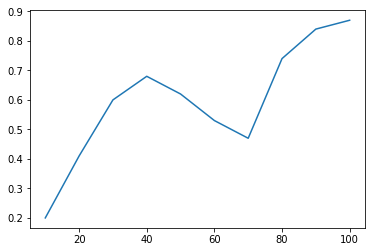

In [29]:
plt.plot(num_training, tab)
plt.show()

In [30]:
tab[2]

0.6

Załóżmy, że możemy pozyskać 30 przykładów i możemy które przykłady chcemy poetykietować. Jak je wybrać?

In [10]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=0.95,random_state=42)
X_labeled.shape


(10, 64)

ZADANIE: Zaimplementuj active learnera z kryterium entropijnym oraz losowym. Porównaj ich działanie na postawionym powyżej problemie

In [33]:
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator
import copy
from scipy import stats
import random

class AL(BaseEstimator):
    def __init__(self, model, X_test, y_test, sampling_style = 'entropy', 
                 sample_num=2, upper_bound = 30, seed=42):
        self.sample_num = sample_num
        self.upper_bound = upper_bound
        self.seed = seed
        self.model = model
        self.model.seed = seed
        self.X_test = X_test
        self.y_test = y_test
        self.sampling_style = sampling_style
        
    def fit(self, X, y):
        num = X.shape[0]    
        X_aug = copy.deepcopy(X)
        y_aug = copy.deepcopy(y)
        X_pool = copy.deepcopy(X_test)
        y_pool = copy.deepcopy(y_test)
        while num <= self.upper_bound-X.shape[0]:
            X_aug, y_aug, X_pool, y_pool = self.active_label(X_aug, y_aug, X_pool, y_pool)
            num += self.sample_num
        self.model.fit(X_aug, y_aug)
        return self
    
    def active_label(self, X, y, X_pool, y_pool):
        
        # Train the model and creat the pseudo-labels
        self.model.fit(X, y)
        proba_labels = self.model.predict_proba(X_pool)
        # Take a subset of the pool set with pseudo-labels and append in onto the training set
        if self.sampling_style == 'entropy':
            ind_selected = self.select_by_entropy(proba_labels)
        else:
            ind_selected = self.select_by_sampling(proba_labels)
        X_aug = np.vstack((X, X_pool[ind_selected]))
        y_aug = np.hstack((y, y_pool[ind_selected]))
        X_pool = np.delete(X_pool, ind_selected, 0)
        y_pool = np.delete(y_pool, ind_selected, 0)
        
        return X_aug, y_aug, X_pool, y_pool
    
    def select_by_sampling(self, proba):
        print("sampling")
        return random.sample(range(len(proba)), self.sample_num)
    
      
    def select_by_entropy(self, proba):
        print("entropy")
        entropies = stats.distributions.entropy(proba.T)
        inds = (np.argsort(entropies)[::-1]).tolist()
        return inds[:self.sample_num]
    
    def predict(self, X):
        return self.model.predict(X)
        


ZADANIE: Użyjmy entropijnego

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import linear_model

model = AL(
    linear_model.LogisticRegression(C=1e5),
    X_unlabeled,
    y_unlabeled,
    'entropy'
)
# Train the model and use it to predict
model.fit(X_labeled, y_labeled)


entropy
entropy
entropy
entropy
entropy
entropy


AL(X_test=array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  3., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  1., ..., 16.,  0.]]),
  model=LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  sample_num=2, sampling_style='entropy', seed=42, upper_bound=30,
  y_test=array([8, 8, ..., 1, 2]))

In [35]:
X_train.shape

(200, 64)

In [36]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.805
0.8


ZADANIE: Użyjmy randomowego

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import linear_model

model_random = AL(
    linear_model.LogisticRegression(C=1e5),
    X_unlabeled,
    y_unlabeled,
    'random'
)
# Train the model and use it to predict
model_random.fit(X_labeled, y_labeled)


sampling
sampling


AL(X_test=array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  3., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  1., ..., 16.,  0.]]),
  model=LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  sample_num=10, sampling_style='random', seed=42, upper_bound=30,
  y_test=array([8, 8, ..., 1, 2]))

In [17]:
y_train_pred = model_random.predict(X_train)
y_test_pred = model_random.predict(X_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.58
0.64


ZADANIE: Weź jakiś klasyfikator nieliniowy i spradź działanie

In [31]:


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# from sklearn.ensemble import GradientBoostingRegressor


model = AL(
    LinearDiscriminantAnalysis(),
    X_unlabeled,
    y_unlabeled,
    'entropy'
)
# Train the model and use it to predict
model.fit(X_labeled, y_labeled)


entropy
entropy


C:\Users\marek\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\marek\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


AL(X_test=array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  3., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  1., ..., 16.,  0.]]),
  model=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001),
  sample_num=10, sampling_style='entropy', seed=42, upper_bound=30,
  y_test=array([8, 8, ..., 1, 2]))

In [32]:
y_train_pred = model_random.predict(X_train)
y_test_pred = model_random.predict(X_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.58
0.64
